# Notebook on the dynamics of the creation and disappearance of links

This notebook will try to analyze recently created links (less than one year) based on data from facebook gathered as part of the algopol investigation.

## What I can do (at the moment)

1. Compute and Identify recent alters for an ego
1. Compute and plot frequencies and percentages of recent alters for a given ego
1. Compute and plot the proportion of recent alters per year for a given ego


## What I can't do (at the moment)


1. Compute and plot proportions against a given socio-economical category or a demographic profile.
1. Compute, label and plot against specific reasons. I don't have the "why" of an interaction.
1. Compute lost alters (unfriend, blocks)

## What I need 

1. Egos Age
1. Alters Age
1. The reason behind the interaction
1. An union of all the egos to compute and plot the mean and median number of recent alters for the whole dataset
1. An union of all the egos (in a specific and relevant category) to compute and plot the mean and median number of recent alters for a specific category.

## Computing the recent alter distribution

### Without Pandas (except for plotting)

In [1]:
import pandas as pd
import os
from statistics import mean
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import dask.dataframe as dd
sns.set()


In [2]:
def get_ego_id(ego_path):
    return os.path.splitext(os.path.basename(ego_path))[0][:8]

In [3]:
def add_value_to_dict(dico, key, val):
    if key in dico.keys():
        dico[key] = dico[key] + val
    else:
        dico[key] = val

In [4]:
def mean_recent_alter_ego(csvobj):
    len_recent_alter = 0
    count_recent_alter = 0
    for row in csvobj:
        len_recent_alter += 1
        count_recent_alter += int(row['AlterCount'])
    if len_recent_alter > 0:
        return count_recent_alter / len_recent_alter
    return -1

In [5]:
def read_csv_in_folder(folder_path):
    mean_alter_dict = {}
    nb_ego_treated = 0
    for file in os.listdir(folder_path):
        filename = os.fsdecode(file)
        path_to_file = os.path.join(folder_path,filename)
        if filename.endswith(".csv"):
            with open(path_to_file, newline='') as csvfile:
                csvobj = csv.DictReader(csvfile)
                id_ego = get_ego_id(filename)
                mean_recent_alter = round(mean_recent_alter_ego(csvobj))
                if mean_recent_alter != -1:
                    add_value_to_dict(mean_alter_dict,mean_recent_alter,1)
    return mean_alter_dict

In [6]:
folder_path = "sample_data_recent_alter_csv/csv"
mean_alter_dict = read_csv_in_folder(folder_path)

In [7]:
df = pd.DataFrame(mean_alter_dict.items())
df = df.rename(columns={0:"Mean", 1:"Nbego"})

In [242]:
g = sns.catplot(x="Mean", y="Nbego",data=df, kind="bar", height=30, aspect=30/20)
g = g.set_xticklabels(g.ax.get_xticklabels(), rotation=45, ha="right")

AttributeError: 'DataFrame' object has no attribute 'get'

### With Dask and Pandas 

In [233]:
df_dask = dd.read_csv('sample_data_recent_alter_csv/csv/*.csv',include_path_column=True)

In [234]:
df_dask = df_dask.drop('Month',axis=1)
df_dask = df_dask.drop('Year',axis=1)

In [235]:
df_pd = df_dask.compute()

In [236]:
df_pd = df_pd.groupby('path').agg(Alter_count_mean=('AlterCount','mean')).reset_index()

In [237]:
df_pd = df_pd.groupby('Alter_count_mean').agg(Nbego=('Alter_count_mean','count')).reset_index()

In [238]:
df_pd['quintiles'] = pd.qcut(df_pd['Alter_count_mean'], 5)

In [239]:
newdf = df_pd[['quintiles','Nbego']].groupby('quintiles').sum().reset_index()

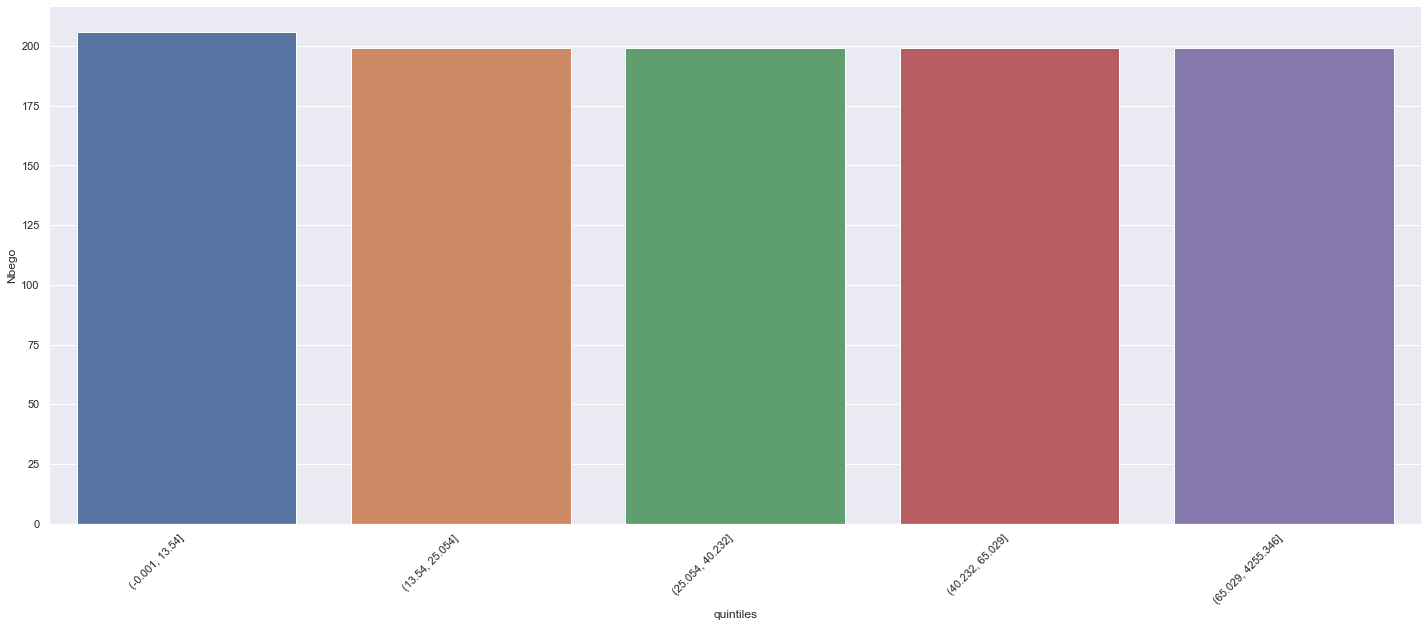

In [240]:
g = sns.catplot(x="quintiles", y="Nbego",data=newdf, kind="bar", height=8, aspect=20/8)
g = g.set_xticklabels(g.ax.get_xticklabels(), rotation=45, ha="right")